# Setup

In [ ]:
#import packages
import sys, os, random, requests, json
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from google.colab import drive, data_table

In [ ]:
#set up paths for local modules and data sources
drive.mount('/content/drive',force_remount=True)
sys.path.append('*** working directory ***')
stim_path = "./Stimuli/"
data_path = "./Results/"

Mounted at /content/drive


In [ ]:
#set environment variable with API key
%env OPENAI_API_KEY = Bearer ***your-key***

In [ ]:
# read in stimuli
# action_data = pd.read_csv(stim_path + "action_neurips.csv", header=None)
# action_list_all = action_data[0].tolist()

action_data = pd.read_csv(stim_path + "actions_subset_uncor.csv", header=0)
action_list_all = action_data["Item"][0:15].tolist()

In [ ]:
action_list_all

['sitting in a chair',
 'running into a burning building to save a precious antique',
 'watching a rival sports team lose badly',
 'running a marathon for charity',
 'running a marathon for fitness',
 'mowing the lawn',
 'donating money to charity',
 'writing letters to the local government to support a homeless shelter',
 'helping someone change their flat tire on the road',
 'volunteering at a voting location',
 'painting a wall',
 'taking a day off to go to the spa',
 'winning millions in the lottery',
 'watching your favorite movie',
 'cleaning up litter in a rough neighborhood']

# Embedding Projection

In [ ]:
#@title define all functions
def getEmbeddings(text):
    url = 'https://api.openai.com/v1/embeddings'
    headers = {
      "Content-Type": "application/json",
      "Authorization": os.getenv("OPENAI_API_KEY")
      }
    data = {
        "input": text,
        "model": "text-embedding-ada-002"
    }
    response = requests.post(url, headers=headers, json=data)

    return response.json()

def return_embeddings_diff(attributes_a, attributes_b):
  '''
  Pass two sets of attributes and get all vector differences of all a-b combinations
  '''
  emb_high = pd.DataFrame()
  emb_low = pd.DataFrame()

  #loop through each attribute set and save the embeddings in two dataframes
  for a in range(len(attributes_a)):
    #get embedding of the high, low, and compute difference
    this_emb = getEmbeddings(attributes_a[a])
    emb_high.insert(loc=0, column=a, value=this_emb["data"][0]["embedding"])

  for b in range(len(attributes_b)):
    #get embedding of the high, low, and compute difference
    this_emb = getEmbeddings(attributes_b[b])
    emb_low.insert(loc=0, column=b, value=this_emb["data"][0]["embedding"])

  #get all differences
  vector_diff = pd.DataFrame()

  #report correlations
  print(emb_low.corr())
  print(emb_high.corr())

  for a in range(len(attributes_a)):
    for b in range(len(attributes_b)):
      this_col = str(a)+'_'+str(b)
      vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])

  return(vector_diff.mean(axis=1))


def return_list_embeddings(alist):
  '''
  get embeddings for a list of items
  '''
  n_df = pd.DataFrame()
  for i in alist:
    this_em = getEmbeddings(i)["data"][0]["embedding"]
    n_df.insert(loc=0, column=i, value=this_em, allow_duplicates=True)

  return (n_df)


def get_projections(stim_list, moral_v, hedonic_v, movement_v):
  '''
  get projections for list of items
  '''
  #construct dataframe to save items
  projection_df = pd.DataFrame(index=stim_list, columns=['moral_v','hedonic_v','movement_v'], data=0)

  #loop through items to get embeddings in moral, hedonic, and movement vector directions

  for a in stim_list:
    this_em = getEmbeddings(a)["data"][0]["embedding"]
    projection_moral = np.inner(np.array(this_em),np.array(moral_v))
    projection_hedonic = np.inner(np.array(this_em),np.array(hedonic_v))
    projection_movement = np.inner(np.array(this_em),np.array(movement_v))
    projection_df.loc[a, "moral_v"] = projection_moral
    projection_df.loc[a, "hedonic_v"] = projection_hedonic
    projection_df.loc[a, "movement_v"] = projection_movement

  return projection_df

In [ ]:
# get moral direction in GPT embeddings
attributes_morality_high = ['morally virtuous','ethical', 'high moral value']
attributes_morality_low = ['morally wrong','unethical', 'low moral value']
moral_v = return_embeddings_diff(attributes_morality_high, attributes_morality_low)

# get hedonic direction in GPT embeddings
attributes_hedonic_high = ['personally rewarding','pleasurable for me', 'high hedonic value for me']
attributes_hedonic_low = ['personally costly','unpleasurable for me', 'low hedonic value for me']
hedonic_v = return_embeddings_diff(attributes_hedonic_high, attributes_hedonic_low)

# get physicality direction in GPT embeddings
attributes_movement_high = ['physical','bodily action', 'high movement']
attributes_movement_low = ['mental','minimally active', 'low movement']
movement_v = return_embeddings_diff(attributes_movement_high, attributes_movement_low)


In [ ]:
# Report correlation among attribute embeddings
print('Embedding Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(moral_v, hedonic_v)[0, 1], 2)))
print('r(moral, movement) = '+ str(round(np.corrcoef(moral_v, movement_v)[0, 1], 2)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(hedonic_v, movement_v)[0, 1], 2)))

Embedding Correlations:
r(moral, hedonic) = 0.44
r(moral, movement) = 0.09
r(hedonic, movement) = 0.16


In [ ]:
# get projections of stimuli onto each vector direction
item_projections = get_projections(action_list_all, moral_v, hedonic_v, movement_v)

In [ ]:
print('Item Embedding Projection Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(item_projections["moral_v"], item_projections["hedonic_v"])[0, 1], 3)))
print('r(moral, movement) = '+ str(round(np.corrcoef(item_projections["moral_v"], item_projections["movement_v"])[0, 1], 3)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(item_projections["hedonic_v"], item_projections["movement_v"])[0, 1], 3)))

Item Embedding Projection Correlations:
r(moral, hedonic) = 0.799
r(moral, movement) = 0.112
r(hedonic, movement) = 0.041


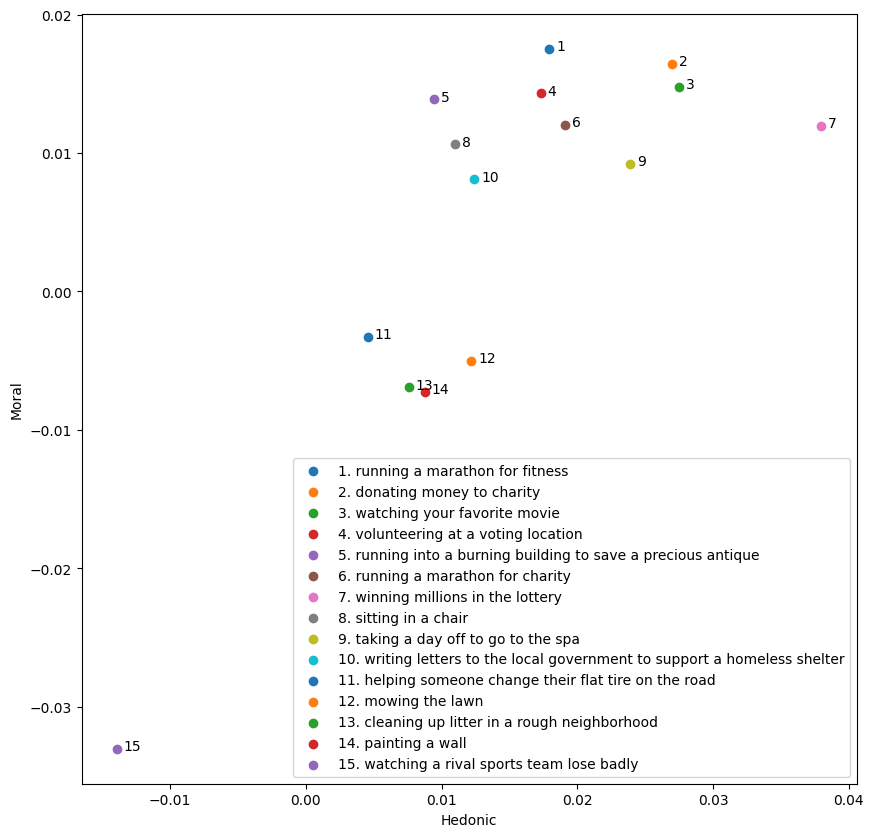

In [ ]:
# Plot batch 1, Moral x Hedonic

# sort proections by morality before plotting
item_projections_1 = item_projections[:18].sort_values('moral_v', ascending=False)


fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap("tab20")

plot_i = 1
for i in range(len(item_projections_1)):
    x = item_projections_1['hedonic_v'].iloc[i]
    y = item_projections_1['moral_v'].iloc[i]
    colors = cmap(i/len(item_projections_1))
    l = str(plot_i) + '. ' + item_projections_1.index[i].lstrip('[').rstrip(']')
    ax.scatter([x],[y], label=l)
    ax.annotate(plot_i, (item_projections_1['hedonic_v'][i]+.0005, item_projections_1['moral_v'][i]-.0001))
    plot_i += 1

ax.set_xlabel('Hedonic')
ax.set_ylabel('Moral')
ax.legend()

# Prompting

In [ ]:
# @title promptGPT
def promptGPT(prompt_message_list, gpt_temperature=0):
  gpt_url = "https://api.openai.com/v1/chat/completions"
  gpt_headers = {
    "Content-Type": "application/json",
    "Authorization": os.getenv("OPENAI_API_KEY")
    }
  gpt_data = {
        "model": "gpt-3.5-turbo-1106",
        "response_format": {"type": "json_object"}, # only works on 3.5-turbo-1106, 4 and above
        "temperature": gpt_temperature,
        "messages": prompt_message_list,
    }
  response = requests.post(gpt_url, headers=gpt_headers, json=gpt_data)
  output = response.json()['choices'][0]['message']['content']

  return output

In [ ]:
# @title prompt_sort
def prompt_sort(action_list, dimension, context=""):
  """
  Given a list of actions to sort, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the ranking results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #randomize the order of the list
  random.shuffle(action_list)

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the relative moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of their relative moral virtue according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array<string>: A sorted list of actions, starting with the most morally wrong, and ending with the most morally virtuous from Ziv's perpsective."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["walk a dog", "rob a bank", "rescue a cat", "steal food"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["rob a bank", "steal food", "walk a dog", "rescue a cat"]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the relative hedonic reward of different actions.
Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of their relative hedonic reward for Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array<string>: A sorted list of actions, starting with the
worst and least hedonically rewarding, and ending with the best and most hedonically rewarding from Ziv's perpsective."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["miss the bus", "win a sweepstakes", "eat a meal", "lose my wallet"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["lose my wallet", "miss the bus", "eat a meal", "win a sweepstakes"]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement
of different actions. Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of how much physical movement they involve.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:

1. ranking - Array<string>: A sorted list of actions, starting with the
least physical body movement, and ending with the most physical body movement."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["play soccer", "listen to music", "pack boxes", "order coffee at a cafe"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["listen to music", "order coffee at a cafe", "pack boxes", "play soccer"]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]

In [ ]:
# @title prompt_rate_sorted
def prompt_rate_sorted(action_list, dimension, context=""):
  """
  Given a sorted list of actions to rate, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the rating results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the relative moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of their relative moral virtue according to Ziv.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar in terms of moral virtue, and 10 if the actions are very different in terms of moral virtue.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["rob a bank", "steal food", "walk a dog", "rescue a cat"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["rob a bank", 0], ["steal food", 3], ["walk a dog", 10], ["rescue a cat", 6]]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the relative hedonic reward
of different actions. Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of their relative hedonic reward for Ziv.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar
in terms of hedonic reward, and 10 if the actions are very different in terms of hedonic reward.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["lose my wallet", "miss the bus", "eat a meal", "win a sweepstakes"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["lose my wallet", 0], ["miss the bus", 2], ["eat a meal", 9], ["win a sweepstakes", 8]]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement of different actions.
Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of how much physical movement they involve.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar
in terms of amount of physical movement, and 10 if the actions are very different in terms of amount of physical movement.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["listen to music", "order coffee at a cafe", "pack boxes", "play soccer"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["listen to music", 0], ["order coffee at a cafe", 2], ["pack boxes", 6], ["play soccer", 9]]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]

In [ ]:
# @title sort_rate wrapper function
def sort_rate(action_list, dimension):

  # Sort actions
  resp = promptGPT(prompt_sort(action_list, dimension))
  resp_sorted_list = json.loads(resp)['ranking']

  # Rate distance between sorted actions
  resp = promptGPT(prompt_rate_sorted(resp_sorted_list, dimension))
  resp_rated_list = json.loads(resp)['ranking']

  # parse the ratings into a dataframe
  resp_df = pd.DataFrame(resp_rated_list, columns=['item', 'rating'])
  resp_df['rating'] = pd.to_numeric(resp_df['rating'])
  resp_df['rating_sum'] = resp_df['rating'].cumsum()
  resp_df['rescored_' + dimension] = resp_df['rating_sum'] / resp_df['rating_sum'].max() * 100
  resp_df = resp_df.drop(columns=['rating', 'rating_sum'])

  return resp_df

In [ ]:
# run the pipeline and get data!
moral_df = sort_rate(action_list_all, 'moral')
hedonic_df = sort_rate(action_list_all, 'hedonic')
movement_df = sort_rate(action_list_all, 'movement')

full_df = pd.merge(moral_df, hedonic_df, on='item', how='inner')
full_df = pd.merge(full_df, movement_df, on='item', how='inner')

In [ ]:
print('Prompting Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(full_df["rescored_moral"], full_df["rescored_hedonic"])[0, 1], 2)))
print('r(moral, movement) = '+ str(round(np.corrcoef(full_df["rescored_moral"], full_df["rescored_movement"])[0, 1], 2)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(full_df["rescored_hedonic"], full_df["rescored_movement"])[0, 1], 2)))

Prompting Correlations:
r(moral, hedonic) = 0.17
r(moral, movement) = 0.5
r(hedonic, movement) = 0.04


# Prompting Statistics

In [ ]:
# Create list of lists with all items
niter = 100
dimension = 'hedonic'

result_lists = [[action, []] for action in action_list_all]

for i in range(niter):
  result_df = []

  while(len(result_df)<15):
    result_df = sort_rate(action_list_all, dimension)

  for action in action_list_all:
    act_val = result_df[result_df['item'] == action]['rescored_'+ dimension].values[0]
    cur_vals = []
    for row in result_lists:
      if row[0] == action:
        row[1].append(act_val)
        break

In [ ]:
# summary statistics for each item
new_result_lists = []

for row in result_lists:
  if len(row[1]) > 0:
    CI = st.t.interval(0.95, len(row[1])-1, loc=np.mean(row[1]), scale=st.sem(row[1]))
    new_row = [
        row[0],
        max(0, CI[0]), # 0 or low CI
        np.mean(row[1]),
        min(100, CI[1]), # 100 or high CI
        ]
    new_result_lists.append(new_row)
  else:
    print('Need more data for ' + row[0])

new_results_df = pd.DataFrame(new_result_lists, columns=['item', '95CI_Low', 'mean', '95CI_High'])

In [ ]:
new_results_df.to_csv(data_path + 'hedonic_100_iter_results_uncorr14set.csv')

In [ ]:
# # Load and merge dataframes
moral_df_new = pd.read_csv(data_path + 'moral_100_iter_results.csv')
hedonic_df_new =  pd.read_csv(data_path + 'hedonic_100_iter_results.csv')
movement_df_new =  pd.read_csv(data_path + 'movement_100_iter_results.csv')

# moral_df_new = pd.read_csv(data_path + 'moral_100_iter_results_uncorr15set.csv')
# hedonic_df_new =  pd.read_csv(data_path + 'hedonic_100_iter_results_uncorr15set.csv')
# movement_df_new =  pd.read_csv(data_path + 'movement_100_iter_results_uncorr15set.csv')

moral_df_new.columns = ['null', 'item', 'low_moral', 'mean_moral', 'high_moral']
hedonic_df_new.columns = ['null', 'item', 'low_hedonic', 'mean_hedonic', 'high_hedonic']
movement_df_new.columns = ['null', 'item', 'low_movement', 'mean_movement', 'high_movement']

moral_df_new = moral_df_new.drop(columns=['null'])
hedonic_df_new = hedonic_df_new.drop(columns=['null'])
movement_df_new = movement_df_new.drop(columns=['null'])

full_df = pd.merge(moral_df_new, hedonic_df_new, on='item', how='inner')
full_df = pd.merge(full_df, movement_df_new, on='item', how='inner')

In [ ]:
print('Prompting Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(full_df["mean_moral"], full_df["mean_hedonic"])[0, 1], 2)))
print('r(moral, movement) = '+ str(round(np.corrcoef(full_df["mean_moral"], full_df["mean_movement"])[0, 1], 2)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(full_df["mean_hedonic"], full_df["mean_movement"])[0, 1], 2)))

Prompting Correlations:
r(moral, hedonic) = -0.06
r(moral, movement) = 0.49
r(hedonic, movement) = 0.03


In [ ]:
print('Prompting vs Embedding Correlations:')
print('moral r = '+ str(round(np.corrcoef(full_df["mean_moral"], item_projections["moral_v"])[0, 1], 2)))
print('hedonic r = '+ str(round(np.corrcoef(full_df["mean_hedonic"], item_projections["hedonic_v"])[0, 1], 2)))
print('movement r = '+ str(round(np.corrcoef(full_df["mean_movement"], item_projections["movement_v"])[0, 1], 2)))

# Prompting Plots

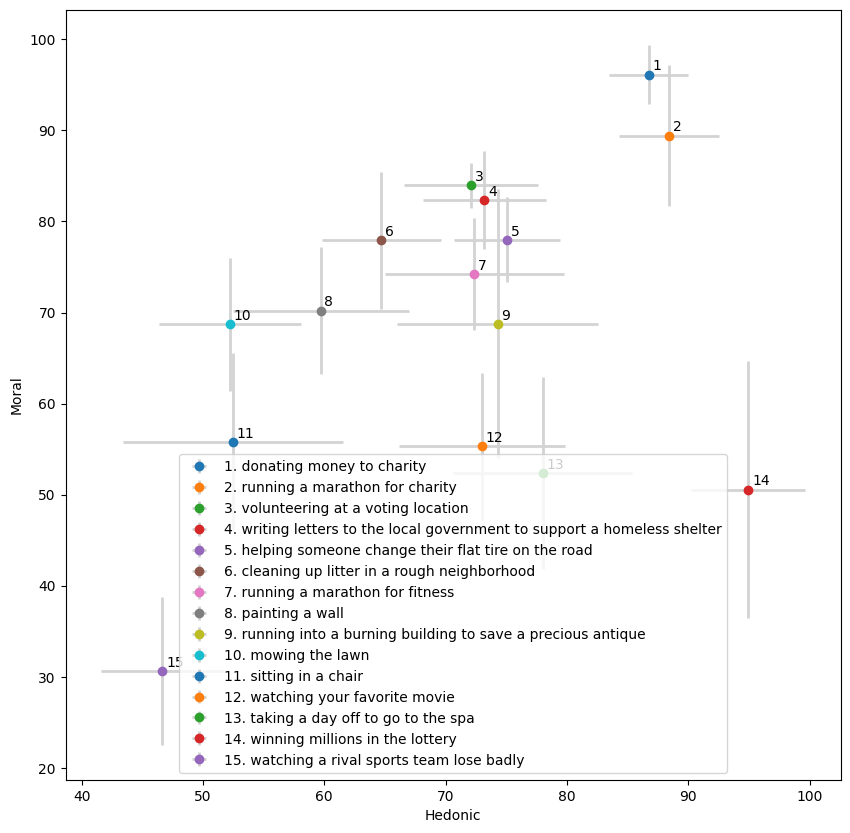

In [ ]:
full_df = full_df[full_df['item'].isin(action_list_all)] # filter to the 15 less correlated items
full_df = full_df.sort_values('mean_moral', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))

plot_i = 1
for i in range(len(full_df)):

    # X axis, means with 95% CI low and high values
    x = full_df['mean_hedonic'].iloc[i]
    x_l = full_df['mean_hedonic'].iloc[i] - full_df['low_hedonic'].iloc[i]
    x_h = full_df['high_hedonic'].iloc[i] - full_df['mean_hedonic'].iloc[i]

    # Y axis, means with 95% CI low and high values
    y = full_df['mean_moral'].iloc[i]
    y_l = full_df['mean_moral'].iloc[i] - full_df['low_moral'].iloc[i]
    y_h = full_df['high_moral'].iloc[i] - full_df['mean_moral'].iloc[i]

    l = str(plot_i) + '. ' + full_df['item'].iloc[i].lstrip('[').rstrip(']')
    ax.errorbar(x, y, xerr=[[x_l], [x_h]], yerr=[[y_l], [y_h]], label=l, fmt='o', ecolor='lightgray', elinewidth=2)
    ax.annotate(plot_i, (x+.3, y+.5))

    plot_i += 1

ax.set_xlabel('Hedonic')
ax.set_ylabel('Moral')
ax.legend()

In [ ]:
data_table.DataTable(full_df, include_index = False, num_rows_per_page = 20)

# Judgment Rating Approach

In [ ]:
# @title prompt_rate
def prompt_rate(action_list, dimension, context=""):
  """
  Given a list of actions to sort, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the ranking results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #randomize the order of the list
  random.shuffle(action_list)

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
You must rate them in terms of their moral virtue according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. rating - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. rating from 0 to 10 for this action, where 0 is the most morally wrong, and 10 is the most morally virtuous"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["walk a dog", "rob a bank", "rescue a cat", "steal food"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"rating": [["walk a dog", 5], ["rob a bank", 1],[ "rescue a cat",8],["steal food", 2]]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the hedonic reward of different actions.
Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
You must rate them in terms of their hedonic reward according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. rating - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. rating from 0 to 10 for this action, where 0 is the least hedonically rewarding, and 10 is the most hedonically rewarding"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["miss the bus", "win a sweepstakes", "eat a meal", "lose my wallet"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"rating": [["miss the bus", 3], ["win a sweepstakes", 9], ["eat a meal", 7], ["lose my wallet", 2]]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement of different actions.
Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
You must rate them in terms of how much physical movement they involve.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. rating - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. rating from 0 to 10 for this action, where 0 indicates the least physical body movement, and 10 indicates the most physical body movement"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["play soccer", "listen to music", "pack boxes", "order coffee at a cafe"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"rating": [["play soccer", 9], ["listen to music", 0], ["pack boxes", 6], ["order coffee at a cafe", 2]]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]

In [ ]:
# Create list of lists with all items
resample_size = 20
dimension = 'movement'

result_lists = [[action, []] for action in action_list_all]

for i in range(resample_size):

  # Rate actions
  resp = promptGPT(prompt_rate(action_list_all, dimension))
  resp_list = json.loads(resp)['rating']
  resp_df = pd.DataFrame(resp_list, columns=['item', 'rating'])
  resp_df['rating'] = pd.to_numeric(resp_df['rating'])

  for action in action_list_all:
    act_val = resp_df[resp_df['item'] == action]['rating'].values[0]
    cur_vals = []
    for row in result_lists:
      if row[0] == action:
        row[1].append(act_val)
        break

In [ ]:
# summary statistics for each item
new_result_lists = []

for row in result_lists:
  if len(row[1]) > 0:
    CI = st.t.interval(0.95, len(row[1])-1, loc=np.mean(row[1]), scale=st.sem(row[1]))
    new_row = [
        row[0],
        max(0, CI[0]), # 0 or low CI
        np.mean(row[1]),
        min(10, CI[1]), # 10 or high CI
        ]
    new_result_lists.append(new_row)
  else:
    print('Need more data for ' + row[0])

new_results_df = pd.DataFrame(new_result_lists, columns=['item', '95CI_Low', 'mean', '95CI_High'])

In [ ]:
new_results_df.to_csv(data_path + 'movement_20_iter_results_likert_subset15.csv')

In [ ]:
# Load and merge dataframes

# 15 subset
moral_df_new = pd.read_csv(data_path + 'moral_20_iter_results_likert_subset15.csv')
hedonic_df_new =  pd.read_csv(data_path + 'hedonic_20_iter_results_likert_subset15.csv')
movement_df_new =  pd.read_csv(data_path + 'movement_20_iter_results_likert_subset15.csv')

moral_df_new.columns = ['null', 'item', 'low_moral', 'mean_moral', 'high_moral']
hedonic_df_new.columns = ['null', 'item', 'low_hedonic', 'mean_hedonic', 'high_hedonic']
movement_df_new.columns = ['null', 'item', 'low_movement', 'mean_movement', 'high_movement']

moral_df_new = moral_df_new.drop(columns=['null'])
hedonic_df_new = hedonic_df_new.drop(columns=['null'])
movement_df_new = movement_df_new.drop(columns=['null'])

full_df = pd.merge(moral_df_new, hedonic_df_new, on='item', how='inner')
full_df = pd.merge(full_df, movement_df_new, on='item', how='inner')

In [ ]:
print('Prompting Likert Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(full_df["mean_moral"], full_df["mean_hedonic"])[0, 1], 2)))
print('r(moral, movement) = '+ str(round(np.corrcoef(full_df["mean_moral"], full_df["mean_movement"])[0, 1], 2)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(full_df["mean_hedonic"], full_df["mean_movement"])[0, 1], 2)))

Prompting Likert Correlations:
r(moral, hedonic) = 0.31
r(moral, movement) = 0.55
r(hedonic, movement) = -0.09


# Human Rating

In [ ]:
rating_df = pd.read_csv(data_path + "Neurips_Prolific_20_R.csv")
rating_df = rating_df[rating_df['item'].isin(action_list_all)] # filter to the 15 less-correlated items

In [ ]:
# summary statistics for each item
new_result_lists = []

for row in rating_df.iterrows():
  item = row[1][1]
  vals = row[1][2:]
  CI = st.t.interval(0.95, len(vals)-1, loc=np.mean(vals), scale=st.sem(vals))
  new_row = [
      item,
      max(0, CI[0]), # 0 or low CI
      np.mean(vals),
      CI[1]
      ]
  new_result_lists.append(new_row)

new_results_df = pd.DataFrame(new_result_lists, columns=['item', '95CI_Low', 'mean', '95CI_High'])

In [ ]:
# 15 subset
moral_df_new = new_results_df[:15]
hedonic_df_new =  new_results_df[15:30]
movement_df_new =  new_results_df[30:]

moral_df_new.columns = ['item', 'low_moral', 'mean_moral', 'high_moral']
hedonic_df_new.columns = ['item', 'low_hedonic', 'mean_hedonic', 'high_hedonic']
movement_df_new.columns = ['item', 'low_movement', 'mean_movement', 'high_movement']

full_df = pd.merge(moral_df_new, hedonic_df_new, on='item', how='inner')
full_df = pd.merge(full_df, movement_df_new, on='item', how='inner')

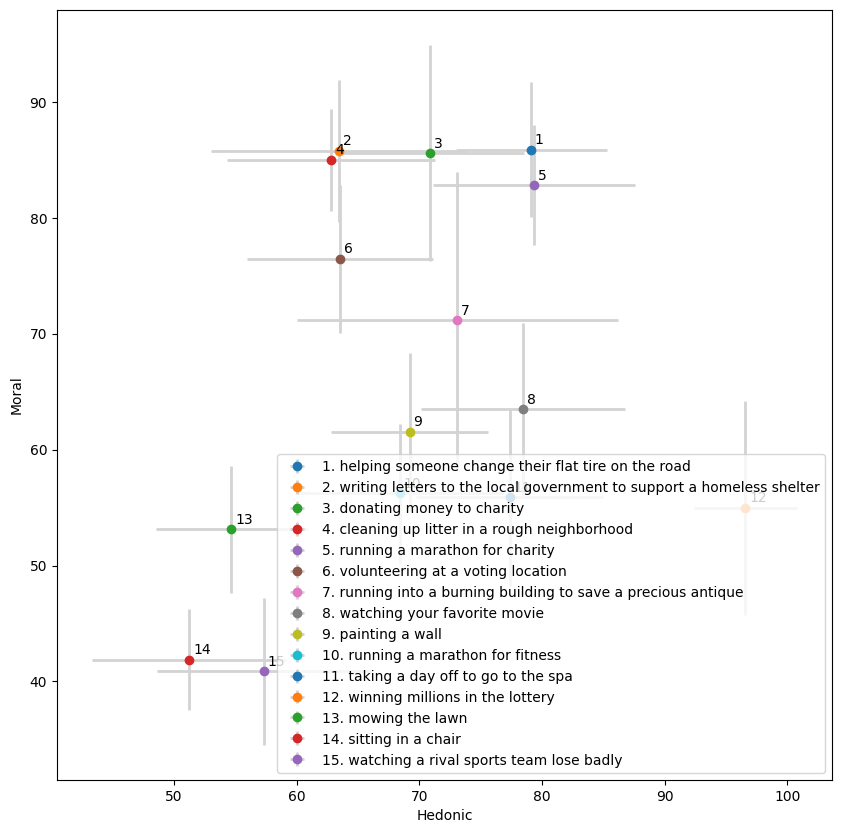

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

full_df = full_df.sort_values('mean_moral', ascending=False)

plot_i = 1
for i in range(len(full_df)):

    # X axis, means with 95% CI low and high values
    x = full_df['mean_hedonic'].iloc[i]
    x_l = full_df['mean_hedonic'].iloc[i] - full_df['low_hedonic'].iloc[i]
    x_h = full_df['high_hedonic'].iloc[i] - full_df['mean_hedonic'].iloc[i]

    # Y axis, means with 95% CI low and high values
    y = full_df['mean_moral'].iloc[i]
    y_l = full_df['mean_moral'].iloc[i] - full_df['low_moral'].iloc[i]
    y_h = full_df['high_moral'].iloc[i] - full_df['mean_moral'].iloc[i]

    l = str(plot_i) + '. ' + full_df['item'].iloc[i].lstrip('[').rstrip(']')
    ax.errorbar(x, y, xerr=[[x_l], [x_h]], yerr=[[y_l], [y_h]], label=l, fmt='o', ecolor='lightgray', elinewidth=2)
    ax.annotate(plot_i, (x+.3, y+.5))

    plot_i += 1

ax.set_xlabel('Hedonic')
ax.set_ylabel('Moral')
ax.legend()

# Archive

In [ ]:
# Create list of lists with all items

rank_list_size = 15
resample_size = 100
dimension = 'hedonic'
result_lists = [[action, []] for action in action_list_all]

for i in range(resample_size):
  action_list = random.sample(action_list_all, rank_list_size)
  result_df = sort_rate(action_list, dimension)

  for action in action_list:
    act_val = result_df[result_df['item'] == action]['rescored_'+ dimension].values[0]
    cur_vals = []
    for row in result_lists:
      if row[0] == action:
        row[1].append(act_val)
        break